### Daily versus hourly ERA5 atmospheric forcing, what does NEMO see?

In [110]:
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range

In [76]:
base  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
dir1h         = f'{base}output/ERA5_1h_tune0_efr005/'
dir1d         = f'{base}output/ERA5_1d_tune0_efr005/'
dir1d_radprec = f'{base}output/ERA5_freq_1h_radprec_1d_else/'
dir1d_wind    = f'{base}output/ERA5_freq_1h_wind_1d_else/'

In [77]:
year = 1979
ds1hS = xr.open_dataset(f'{dir1h}files0/eANT025.L121_1m_{year}0101_{year}1231_SBC.nc')
ds1hT = xr.open_dataset(f'{dir1h}files0/eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
ds1dS = xr.open_dataset(f'{dir1d}files0/eANT025.L121_1m_{year}0101_{year}1231_SBC_compressed.nc')
ds1dT = xr.open_dataset(f'{dir1d}files0/eANT025.L121_1m_{year}0101_{year}1231_grid_T_compressed.nc')

ds1dradS  = xr.open_dataset(f'{dir1d_radprec}files0/eANT025.L121_1m_{year}0101_{year}1231_SBC.nc')
ds1dwindS = xr.open_dataset(f'{dir1d_wind}files0/eANT025.L121_1m_{year}0101_{year}1231_SBC.nc')

In [78]:
def plot_sbc_vars(ds1h, ds1d, variables, vlim, month):
    
    for v,var in enumerate(variables):
        fig, ax = plt.subplots(1,3, figsize=(20,3.5))
        kwags1 = {'ylim':(150,None), 'vmin':vlim[v][0], 'vmax':vlim[v][1], 'cmap':cmocean.cm.balance}
        kwags2 = {'ylim':(150,None), 'vmin':-0.2*vlim[v][1], 'vmax':0.2*vlim[v][1], 'cmap':cmocean.cm.balance}
        ds1h.isel(time_counter=month)[var].plot(ax=ax[0], **kwags1)
        ds1d.isel(time_counter=month)[var].plot(ax=ax[1], **kwags1)
        (ds1h.isel(time_counter=month)[var] - ds1d.isel(time_counter=month)[var]).plot(ax=ax[2], **kwags2)
        ax[0].set_title('Hourly');    ax[1].set_title('Daily');    ax[2].set_title('Hourly - daily');
        
    return

Is there any difference in the monthly averaged atmospheric surface boundary conditions seen between the ERA5 hourly and ERA5 daily experiments?

Variables to look at: sohefldo, soshfldo, qsr_oce, qns, qns_oce, qt_oce, qlw_oce, qsb_oce, qla_oce, taum, windsp, precip, snowpre
- Wind
- Shortwave and longwave radiation 
- Precipitation: snowfall and total
- Humidity
- Surface pressure

Differences:
- Surface wind speeds and stress
- Sensible and latent heat flux over ocean seem quite different
- Non-solar heat flux including evaporation - precipitation seems off, so it could also be a humidity difference
- Sea level pressure (could be a consequence rather than a cause)

--> check ERA5_freq_1h_radprec_1d_else (1h msdwswrf, msdwlwrf, mtpr, msr, everything else at 1d frequency) and ERA5_freq_1h_wind_1d_else (1d u10, v10, everything else at 1h frequency)

Experiment ERA5_freq_1h_wind_1d_else and ERA5_freq_1h_radprec_1d_else have an issue with longitude wrapping, so not informative

In [103]:
month=6

**Wind:** There seems to be a fairly significant decrease in wind stress module in the daily experiment and associated decreases in the wind speeds.

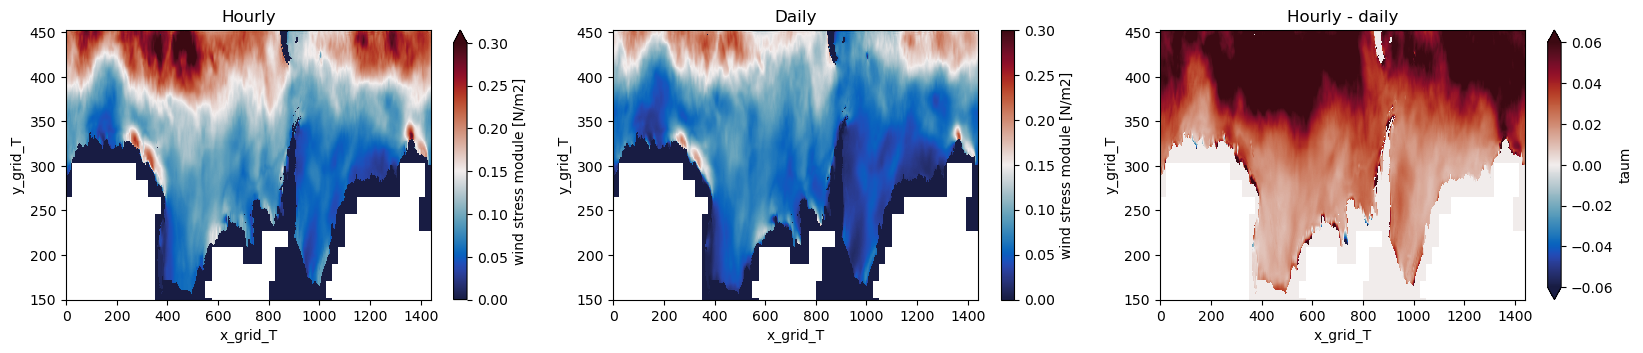

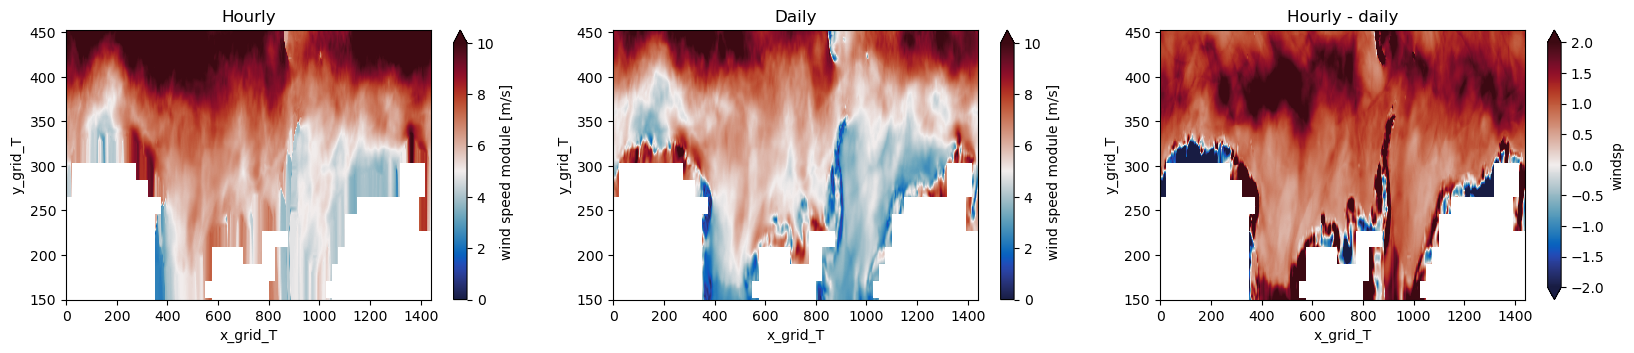

In [97]:
variables = ['taum', 'windsp']
vlim = [(0,0.3), (0,10)]
plot_sbc_vars(ds1hS, ds1dS, variables, vlim, month)

**Precipitation:** Doesn't seem likely to be the cause

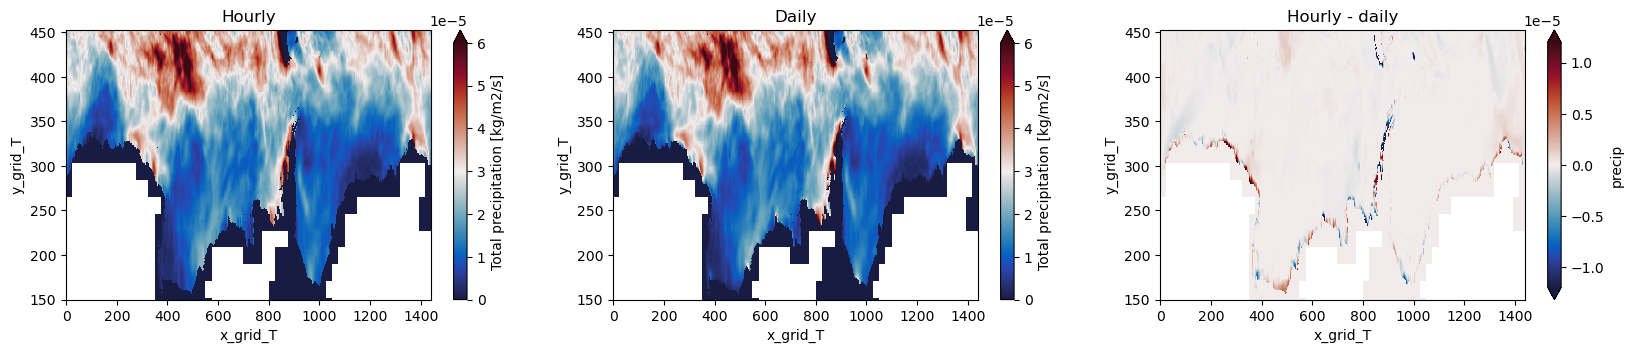

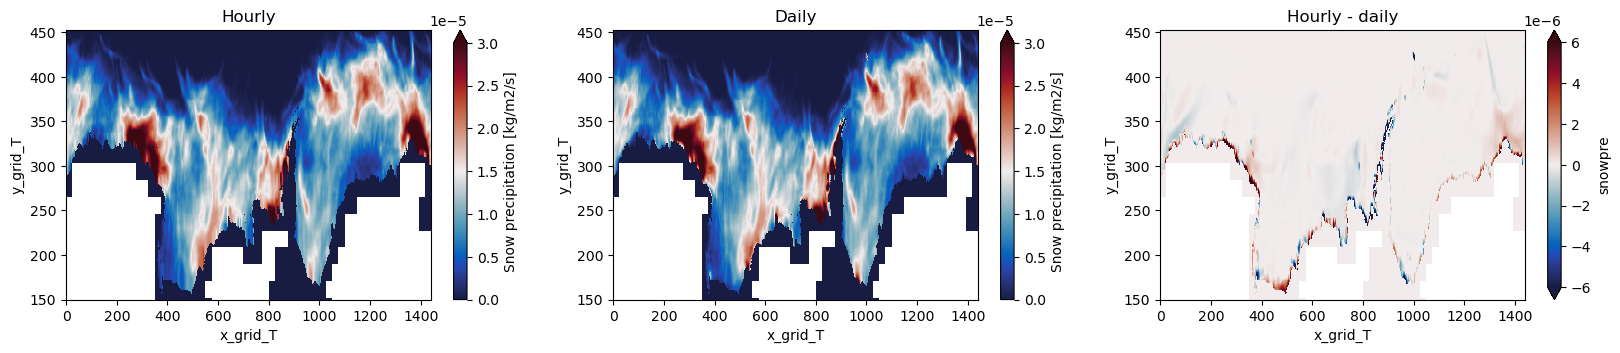

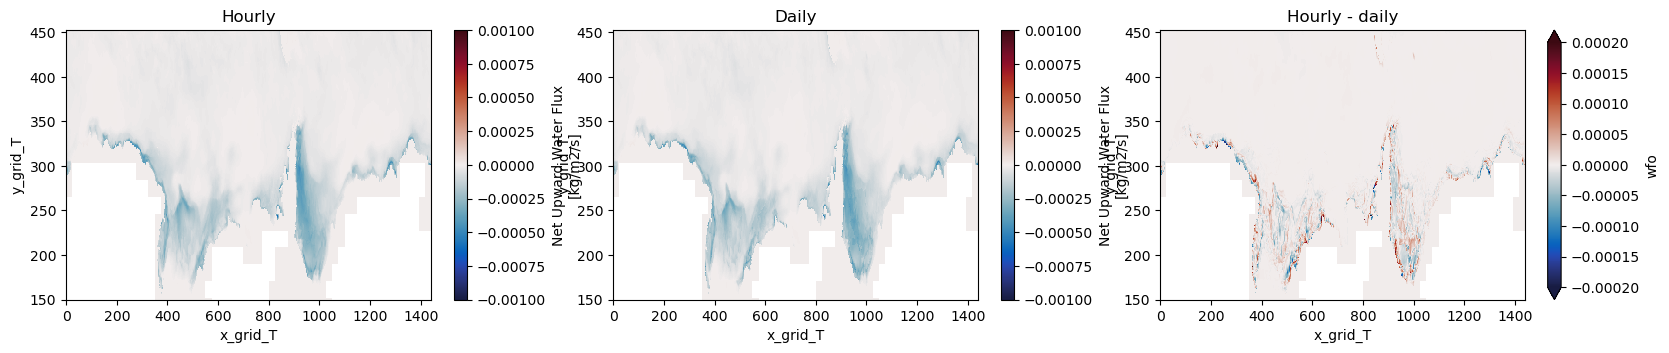

In [98]:
variables = ['precip', 'snowpre', 'wfo']
vlim = [(0,6e-5), (0,3e-5), (-1e-3,1e-3)]
plot_sbc_vars(ds1hS, ds1dS, variables, vlim, month)

**Radiation:** 

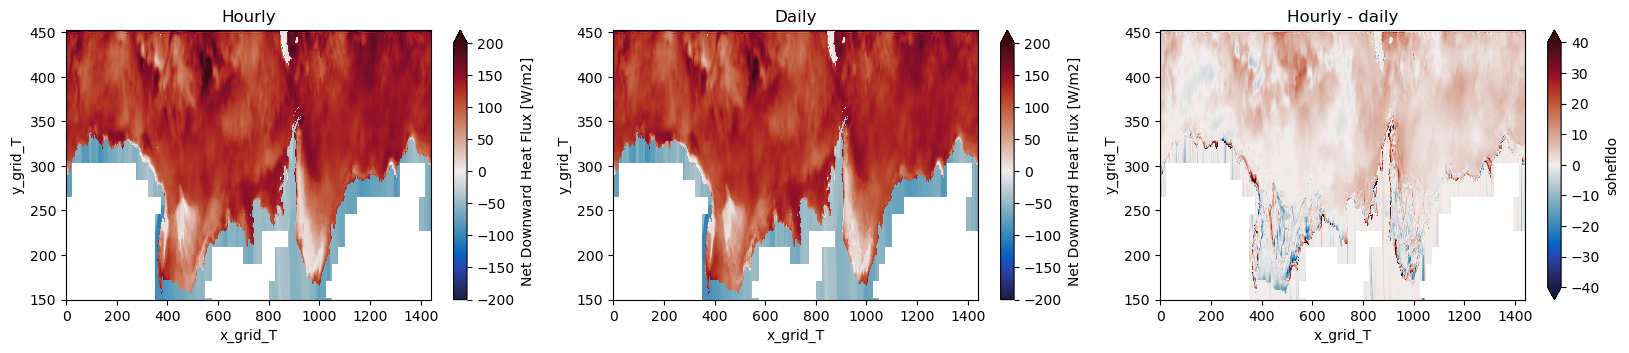

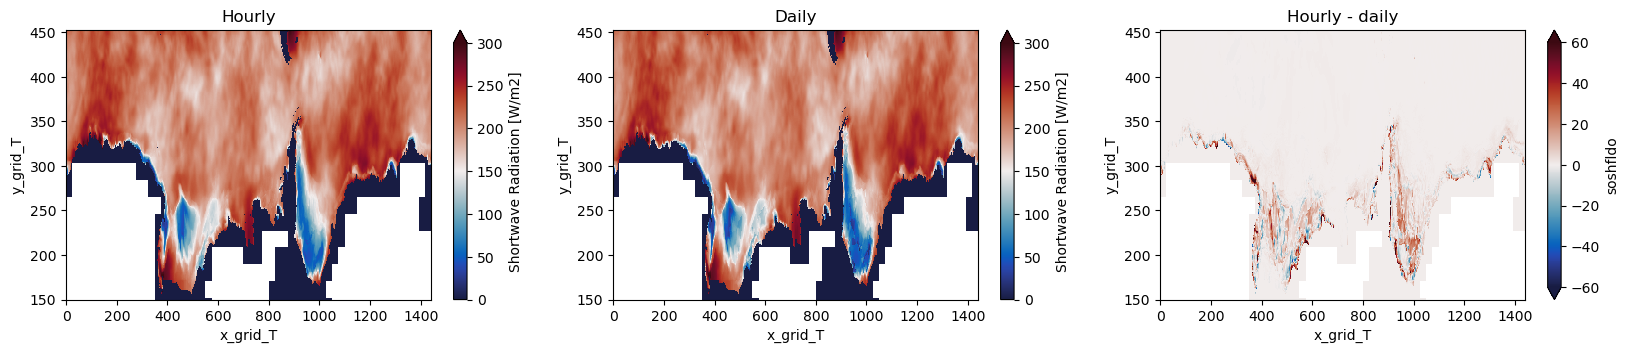

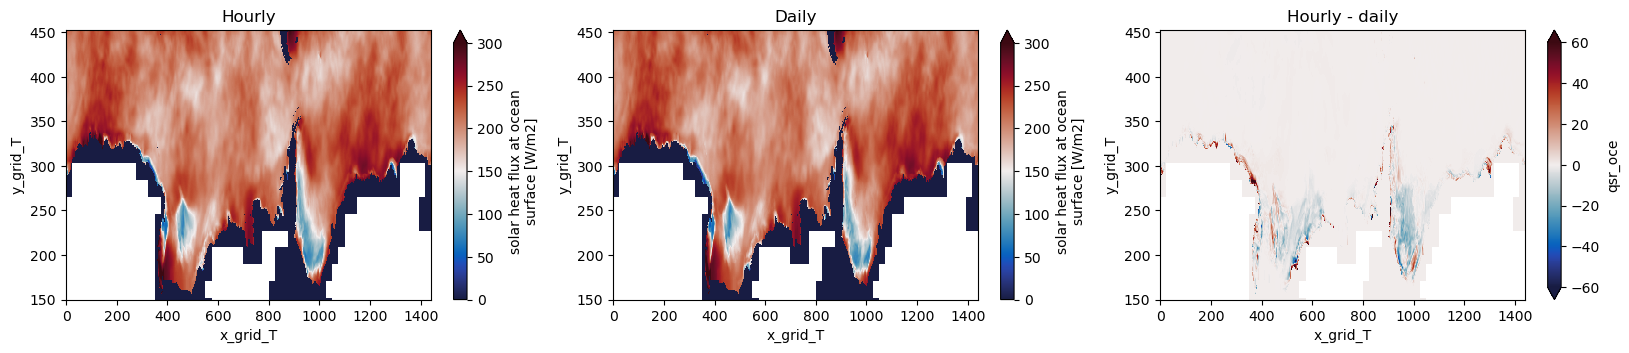

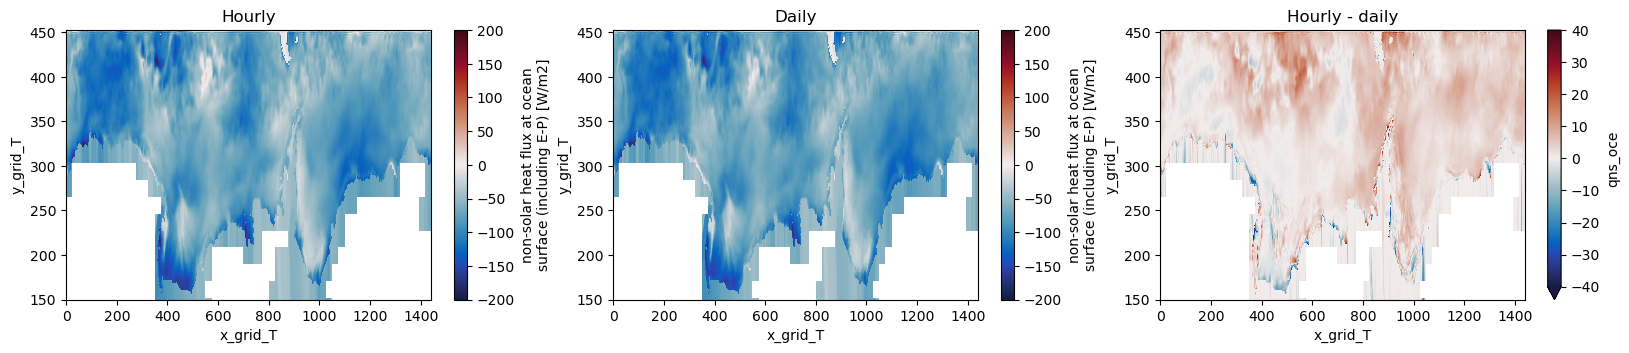

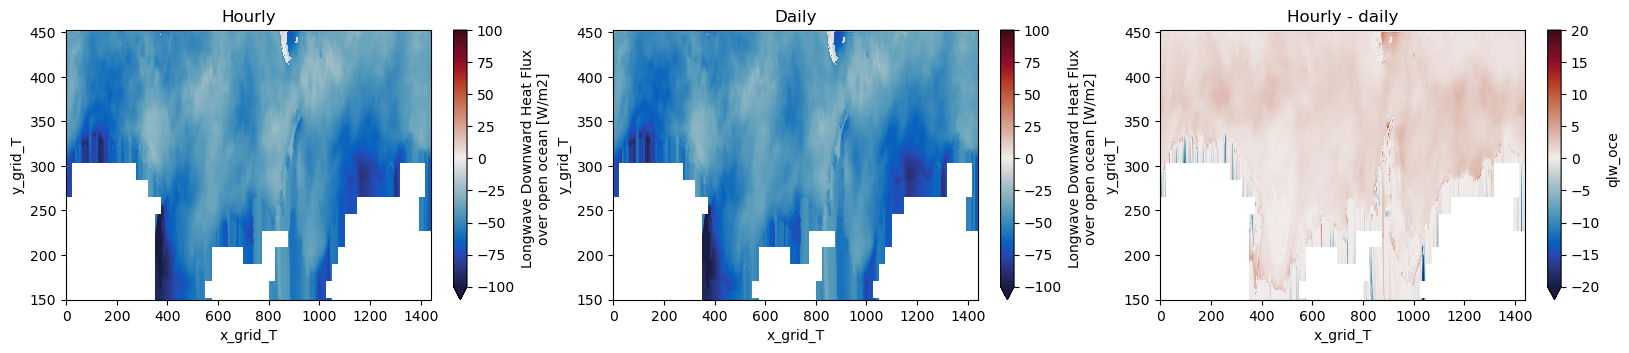

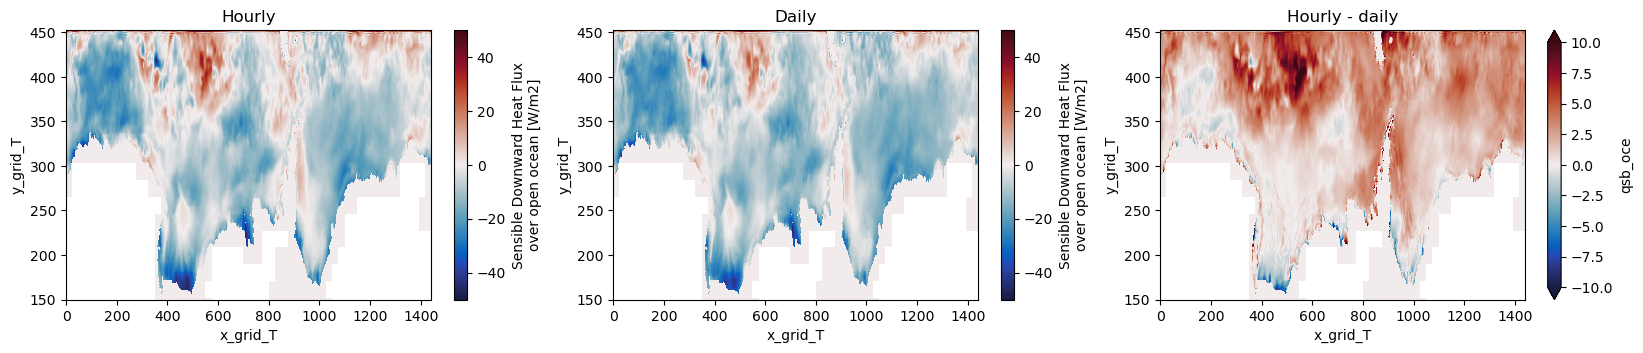

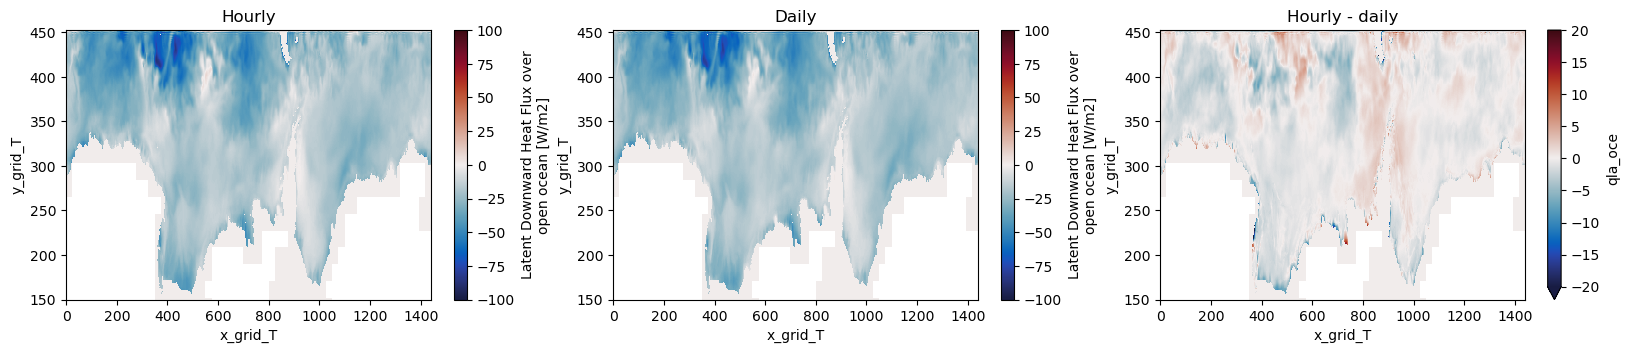

In [99]:
variables = ['sohefldo', 'soshfldo', 'qsr_oce', 'qns_oce', 'qlw_oce', 'qsb_oce', 'qla_oce']
vlim = [(-200,200), (0,300), (0,300), (-200,200), (-100,100), (-50,50), (-100,100)]
plot_sbc_vars(ds1hS, ds1dS, variables, vlim, month)

**Sea level pressure:** 

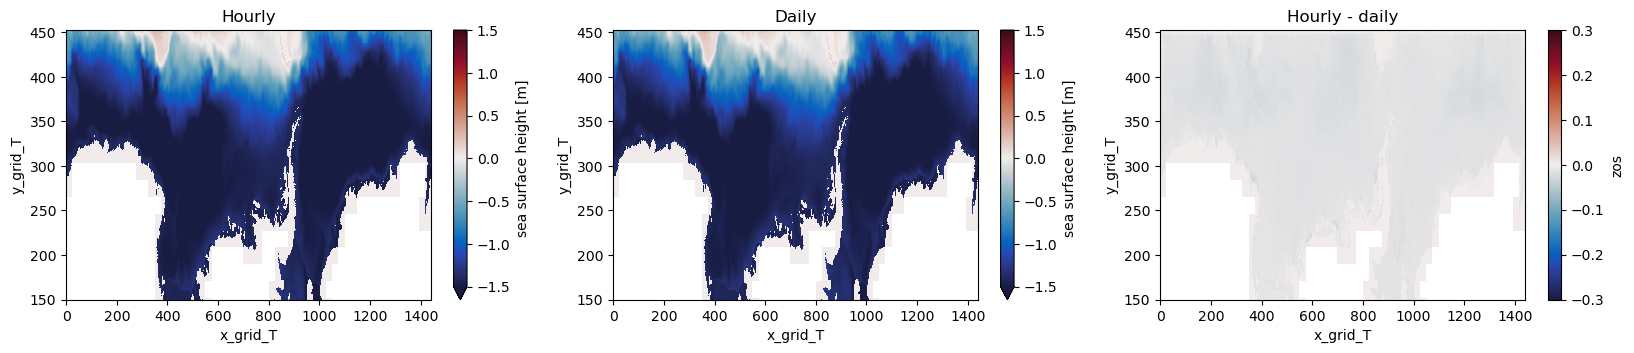

In [100]:
variables = ['zos']
vlim = [(-1.5,1.5)]
plot_sbc_vars(ds1hT, ds1dT, variables, vlim, month)

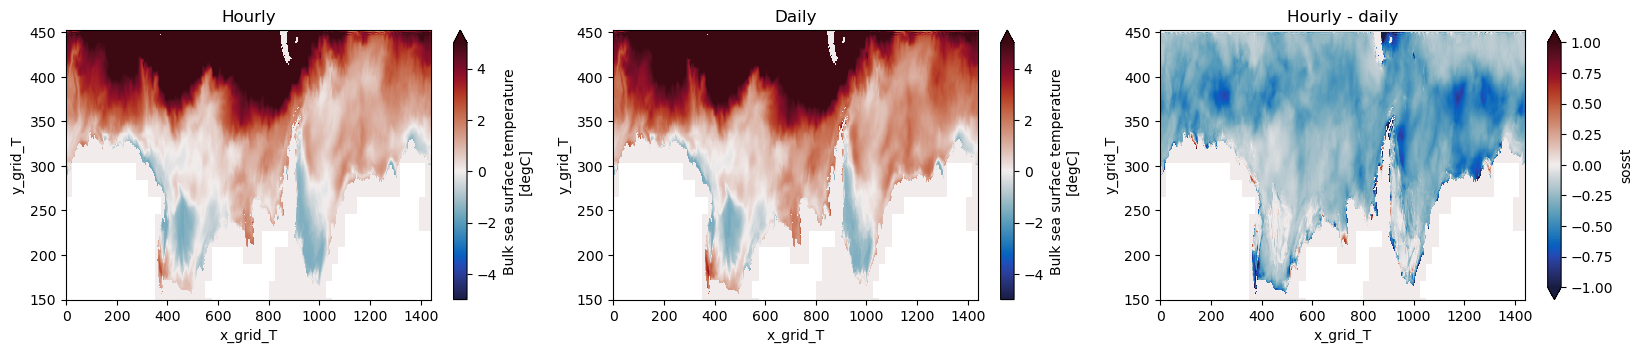

In [102]:
variables = ['sosst']
vlim = [(-5,5)]
plot_sbc_vars(ds1hT, ds1dT, variables, vlim, month)

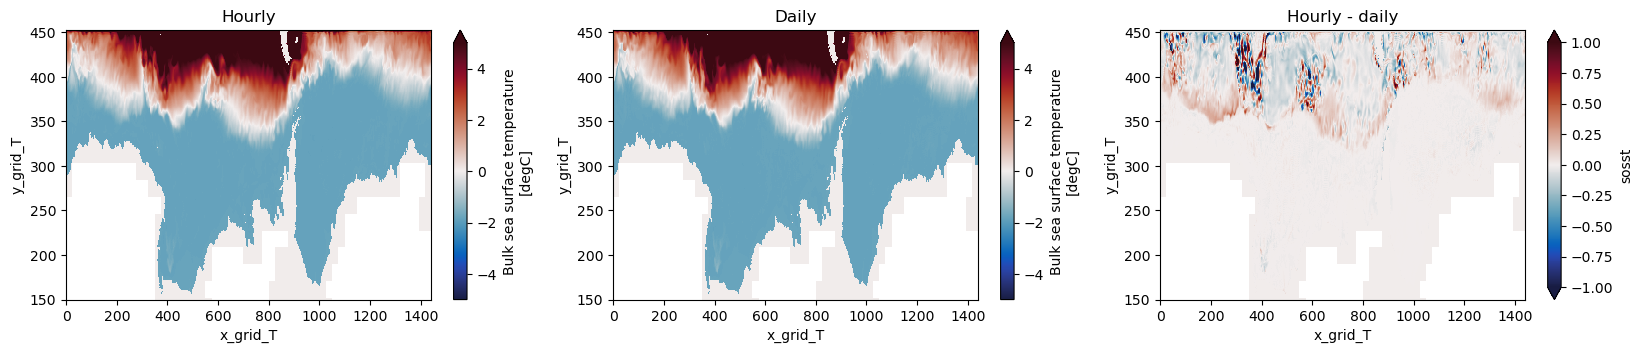

In [105]:
variables = ['sosst']
vlim = [(-5,5)]
plot_sbc_vars(ds1hT, ds1dT, variables, vlim, month)

### Look at daily cycle of wind speeds in forcing:

In [107]:
dirf1h = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/hourly/'
dirf1d = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/daily/files/processed/'

In [125]:
def load_ERA5_var(var):

    f1h = xr.open_dataset(f'{dirf1h}{var}_y1979m01.nc').sel(latitude=slice(-50,-80))
    f1h['longitude'] = fix_lon_range(f1h['longitude'])
    f1h = f1h.sortby('longitude')

    f1d = xr.open_dataset(f'{dirf1d}{var}_time_y1979.nc').sel(latitude=slice(-50,-80)).isel(time=slice(0,31))
    f1d['longitude'] = fix_lon_range(f1d['longitude'])
    f1d = f1d.sortby('longitude')
    
    return f1h, f1d

In [142]:
def plot_ERA5_freqs(f1h, f1d, var):
    
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    f1h[var].where(mask==0).mean(dim=['longitude','latitude']).plot(ax=ax, label=f'hourly {var}')
    f1d[var].where(mask==0).mean(dim=['longitude','latitude']).plot(ax=ax, label=f'daily {var}')
    ax.set_xlabel('Time')
    ax.set_ylabel(var)
    ax.set_title('')
    ax.legend()

    return

In [149]:
f1h_u10, f1d_u10 = load_ERA5_var('u10')
f1h_v10, f1d_v10 = load_ERA5_var('v10')
f1h_t2m, f1d_t2m = load_ERA5_var('t2m')
f1h_d2m, f1d_d2m = load_ERA5_var('d2m')
f1h_msl, f1d_msl = load_ERA5_var('msl')
f1h_mtpr, f1d_mtpr = load_ERA5_var('mtpr')
f1h_msr, f1d_msr   = load_ERA5_var('msr')
f1h_msdwswrf, f1d_msdwswrf = load_ERA5_var('msdwswrf')
f1h_msdwlwrf, f1d_msdwlwrf = load_ERA5_var('msdwlwrf')

In [137]:
mask = xr.open_dataset(f'{dirf1h}../ERA5-landmask.nc').isel(time=0).sel(latitude=slice(-50,-80)).lsm
mask['longitude'] = fix_lon_range(mask['longitude'])

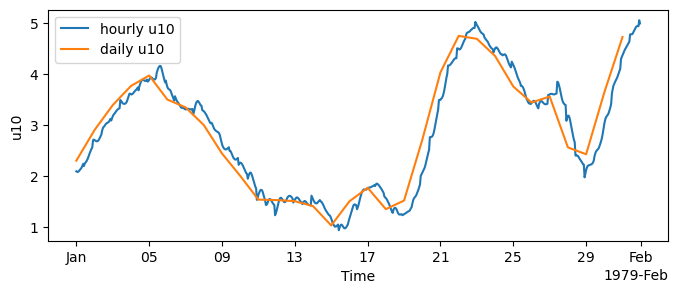

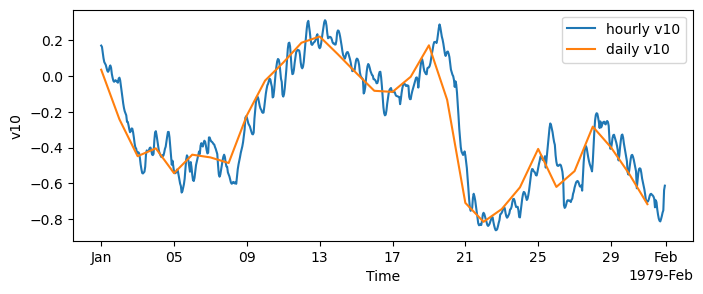

In [143]:
plot_ERA5_freqs(f1h_u10, f1d_u10, 'u10')
plot_ERA5_freqs(f1h_v10, f1d_v10, 'v10')

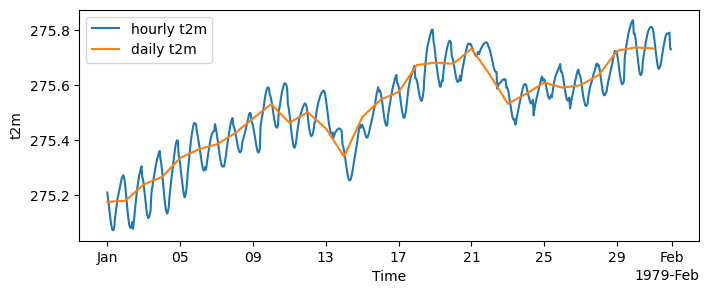

In [144]:
plot_ERA5_freqs(f1h_t2m, f1d_t2m, 't2m')

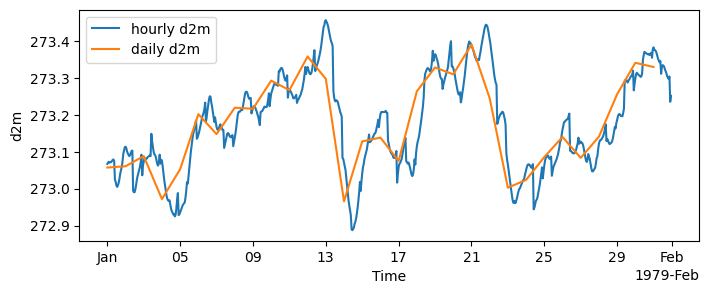

In [145]:
plot_ERA5_freqs(f1h_d2m, f1d_d2m, 'd2m')

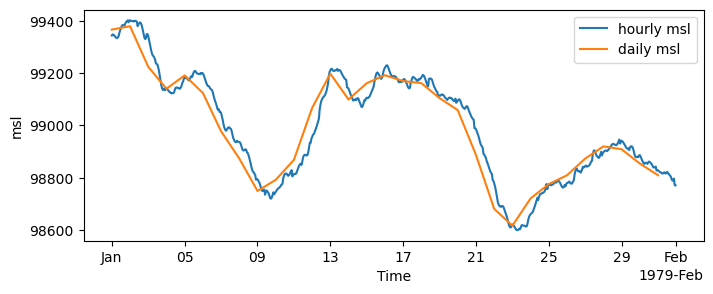

In [147]:
plot_ERA5_freqs(f1h_msl, f1d_msl, 'msl')

In [ ]:
plot_ERA5_freqs(f1h_msdwlwrf, f1d_msdwlwrf, 'msdwlwrf')

In [ ]:
plot_ERA5_freqs(f1h_msdwswrf, f1d_msdwswrf, 'msdwswrf')

In [ ]:
plot_ERA5_freqs(f1h_mtpr, f1d_mtpr, 'mtpr')

In [ ]:
plot_ERA5_freqs(f1h_msr, f1d_msr, 'msr')